In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import one_line_inference

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

### Model

In [3]:
N = 3
nBins = N
obs = jnp.array([70.]*N)
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N,[45]*N,[55]*N)

n_samples = 100_000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

In [4]:
# Truth
model.expected_actualdata([0., 2.])

Array([70., 70., 70.], dtype=float64)

In [5]:
expData_op = make_op.make_op(model)

NameError: name 'make_op' is not defined

### Simple Inference

In [6]:
post_data, post_pred, prior_pred = one_line_inference.sampling(prepared_model, draws=1000, chains=1, step_method='NUTS_with_jitter', tune=1000 )

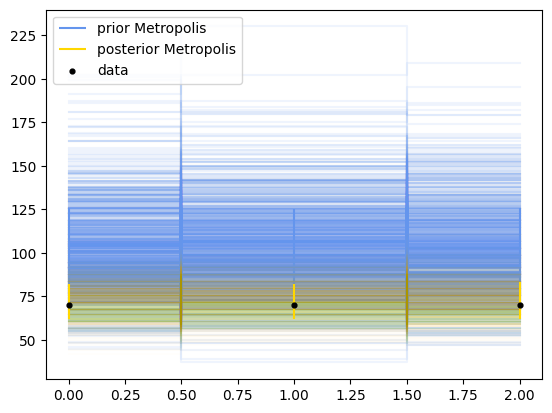

In [5]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.1, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='prior Metropolis');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'gold', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'gold', label='posterior Metropolis')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'')

plt.show()

### Parameter Correlation for Different Backgrounds

In [5]:
post_data, post_pred, prior_pred = one_line_inference.sampling(prepared_model, expData_op, draws=1000, chains=1, step_method='NUTS_with_advi', tune=1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Initializing NUTS using advi...


Convergence achieved at 6300
Interrupted at 6,299 [3%]: Average Loss = 20.128
Interrupted at 6,299 [3%]: Average Loss = 20.128


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


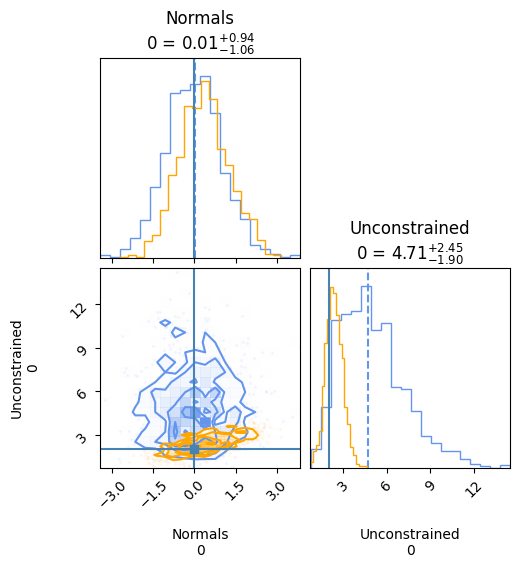

In [8]:
# Parameter Corner Plots
a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, color='cornflowerblue')
corner.corner(post_data.posterior, color = 'orange', truths=[0., 2.], fig=a);

### Traces

In [11]:
post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=10_000, chains=1, step_method='Metropolis', tune=1000 )

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


array([[<AxesSubplot: title={'center': 'Normals'}>,
        <AxesSubplot: title={'center': 'Normals'}>]], dtype=object)

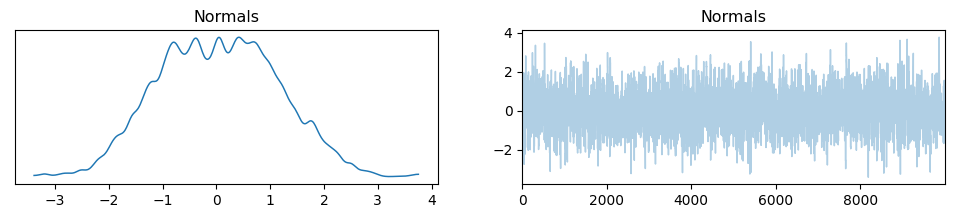

In [12]:
pm.plot_trace(post_data.posterior.Normals)

### Convergence Posterior to Prior
Bin counts:

In [124]:
obs_from_prior = obs
iterations = 1
n_samples = 100

post_normals = []
post_unconstrained = []
post_exp = []

import random

for i in range(iterations):
    post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=n_samples, chains=1, step_method='NUTS_with_advi', tune=1000 )

    # Generating pseudo-data from prior and update the prepared_model
    ii = randint(0, 100 - 1)
    obs_from_prior = prior_pred.prior_predictive.Expected_Data[0][ii] 
    prepared_model = prepare_inference.prepare_model(model=model, observations=obs_from_prior, priors=prior_dict)

    # Fill arrays
    post_exp.append(np.asarray(post_pred.posterior_predictive.Expected_Data[0]))
    # post.append(np.asarray(post_data.Normals))


all_post_averages = []

for i in range(iterations):
    exp_iteration = np.full(nBins, 0)
    for n in range(n_samples):
        exp_iteration = exp_iteration + post_exp[i][n]

    all_post_averages.append(exp_iteration/np.full(nBins, n_samples))


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 9500
Interrupted at 9,499 [4%]: Average Loss = 18.904
Interrupted at 9,499 [4%]: Average Loss = 18.904


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


In [ ]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'black', label='init-prior', zorder=1900);

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),np.asarray(all_post_averages[i]).T, alpha = 0.5, c = 'cornflowerblue', where = 'mid', label='Posteriors from pseudo-data, averaged over all draws')


for i in np.linspace(1, int(iterations-1), int(iterations-1), dtype=int):
    plt.step(np.linspace(0,nBins-1,nBins),np.asarray(all_post_averages[i]).T, alpha = 0.2, c = 'cornflowerblue', where = 'mid')

plt.title('NUTS with init=advi')
plt.legend(loc='upper left')

Parameters:

In [303]:
def prior_pars_data(n_samples):
        with pm.Model() as m:
                pars = prepare_inference.priors2pymc(prepared_model)

                Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars))
                
                prior_pred = pm.sample_prior_predictive(n_samples)

        return np.array(prior_pred.prior.Normals[0]), np.array(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior.Expected_Data[0])

def posterior_from_prior(prior_data, n_samples):
        with pm.Model() as m:
                pars = prepare_inference.priors2pymc(prepared_model)

                
                Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars), observed=prior_data)
                
                step1 = pm.Metropolis()
                post_data = pm.sample(n_samples, chains=1, init='advi')
                post_pred = pm.sample_posterior_predictive(post_data)

        return np.array(post_data.posterior.Normals[0]), np.array(post_data.posterior.Unconstrained[0]), np.array(post_pred.posterior_predictive.Expected_Data[0][0])
        

In [304]:
prior_Normals, prior_Unconstrained, prior_data = prior_pars_data(500)

Sampling: [Expected_Data, Normals, Unconstrained]


In [ ]:
post_n, post_u, post_d = [], [], []
count = 0
for p_d in prior_data:
    count += 1
    print(f'STEP:  {count}')
    a, b, c = posterior_from_prior(p_d, 1)
    post_n.append(a)
    post_u.append(b)
    post_d.append(c)

In [6]:
post_Normals, post_Unconstrained, post_data = [], [], []
for a in post_n:
    post_Normals.append(a)
post_Normals = np.concatenate(post_Normals)

for b in post_u:
    post_Unconstrained.append(b)
post_Unconstrained = np.concatenate(post_Unconstrained)

for c in post_d:
    post_data.append(c)
post_data = np.concatenate(post_data)

NameError: name 'post_n' is not defined

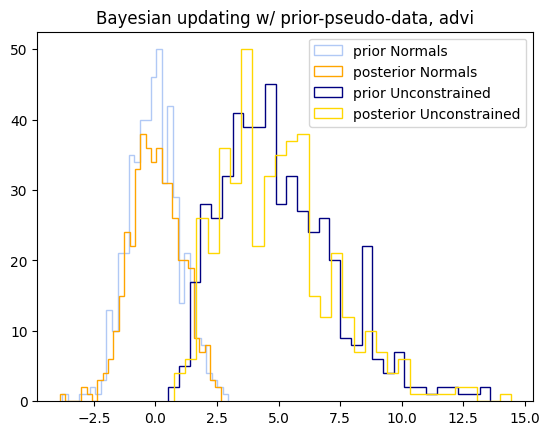

In [313]:
plt.hist(prior_Normals, 30, histtype='step', alpha = 0.5, color='cornflowerblue', label='prior Normals')
plt.hist(post_Normals, 30, histtype='step', color='orange', label='posterior Normals')

plt.hist(prior_Unconstrained, 30, histtype='step', color='navy', label='prior Unconstrained')
plt.hist(post_Unconstrained, 30, histtype='step', color='gold', label='posterior Unconstrained')

plt.legend()
plt.title('Bayesian updating w/ prior-pseudo-data, advi')
plt.show()

# plt.hist(prior_data, histtype='step', label='prior data')
# plt.hist(post_data, histtype='step', label='posterior data')

### Autocorrelation and Thinning

In [29]:
post_data, post_pred, prior_pred = one_line_inference.sampling(prepared_model, draws=4000, chains=1, step_method='NUTS_with_jitter', tune=1000 )

/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (4000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [14]:
thinned_posterior = post_data.posterior.thin(6)

In [ ]:
az.plot_autocorr(post_data)
az.plot_autocorr(thinned_posterior)

plt.show()

array([<AxesSubplot: title={'center': 'Normals\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
       <AxesSubplot: title={'center': 'Unconstrained\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
      dtype=object)

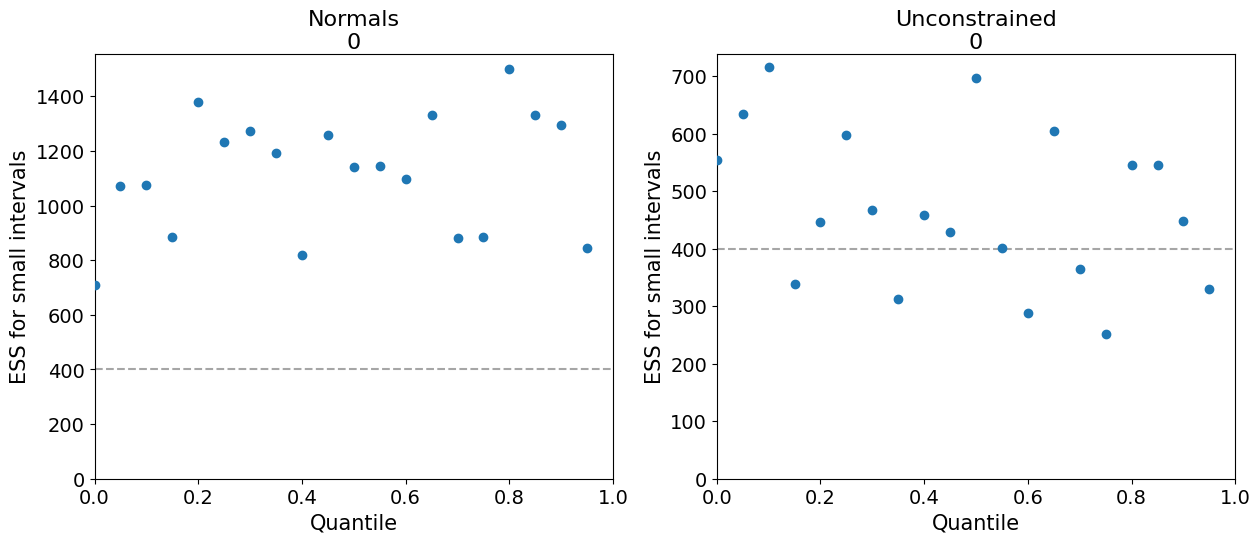

In [23]:
az.plot_ess(post_data.posterior)

array([<AxesSubplot: title={'center': 'Normals\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
       <AxesSubplot: title={'center': 'Unconstrained\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
      dtype=object)

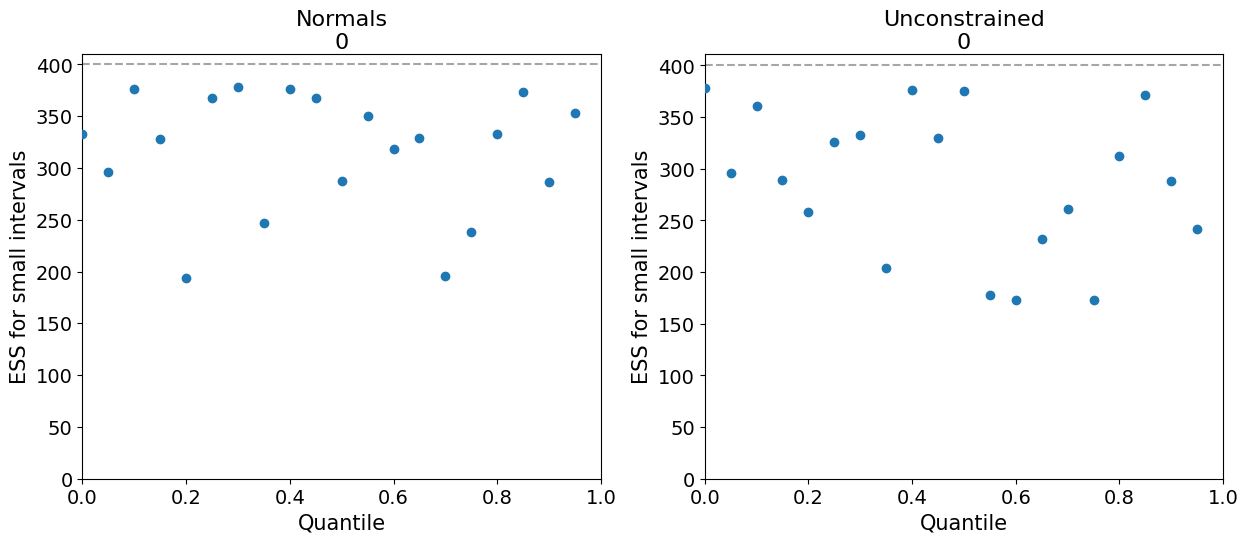

In [24]:
az.plot_ess(post_data.posterior.thin(12))

array([<AxesSubplot: title={'center': 'Normals\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
       <AxesSubplot: title={'center': 'Unconstrained\n0'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

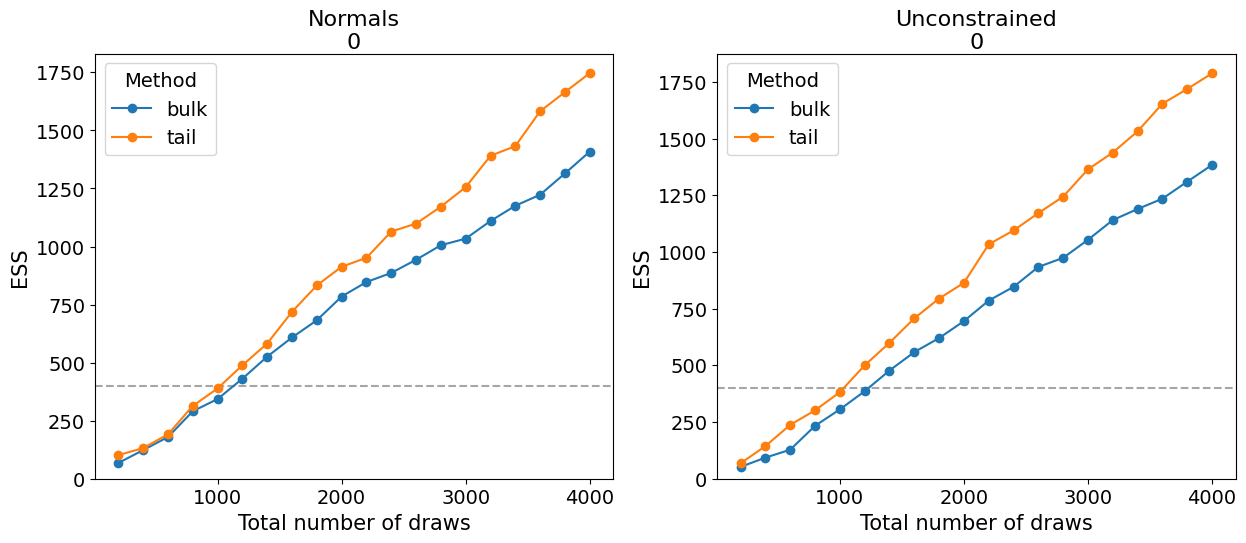

In [30]:
az.plot_ess(
    post_data, kind="evolution",
)

(array([ 6., 15., 22., 42., 59., 51., 81., 40., 33., 16., 15., 14.,  8.,
         4.,  0.,  4.,  0.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ 0.80296524,  1.4388164 ,  2.07466755,  2.7105187 ,  3.34636985,
         3.982221  ,  4.61807215,  5.2539233 ,  5.88977445,  6.52562561,
         7.16147676,  7.79732791,  8.43317906,  9.06903021,  9.70488136,
        10.34073251, 10.97658366, 11.61243482, 12.24828597, 12.88413712,
        13.51998827, 14.15583942, 14.79169057, 15.42754172, 16.06339287,
        16.69924403, 17.33509518, 17.97094633, 18.60679748, 19.24264863,
        19.87849978]),
 <BarContainer object of 30 artists>)

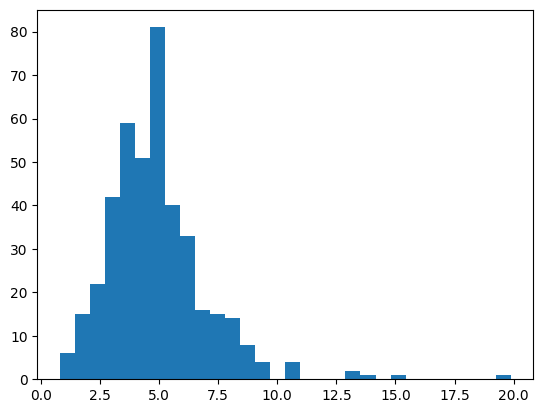

In [22]:
plt.hist([7.316404678924425, 3.3828382629289835, 4.529836549464195, 4.426056097590188, 9.225831384040628, 5.296059666460251, 5.737557068401675, 4.9076307419828815, 6.141491987147511, 2.586688967044821, 1.0325385792611395, 3.482640943989905, 3.090103450799832, 2.4915493157414237, 4.452872337709235, 3.3826196523281316, 2.8199246248803345, 3.8227079224202654, 4.897360546683635, 7.852483649258152, 4.008620941215775, 3.014146844634276, 6.136057525714314, 8.456086990763962, 4.00324652011616, 7.680010890252985, 6.698752013209812, 7.841544623509562, 1.9359397220627141, 4.240093108468801, 5.408749098509022, 3.5598846331182217, 3.8057234809728366, 4.999999999999999, 4.1243819723785675, 8.215602988575966, 3.9400038951249168, 8.517550748196422, 3.9238392723498317, 2.563288359284596, 4.999999999999999, 4.999999999999999, 3.6253183378352003, 1.927349761696593, 3.9330293243448673, 3.374841970627675, 6.051891359513668, 3.085511868752542, 1.9996053275273524, 1.7016218346995777, 3.3585015639741895, 3.666708345563978, 10.698938023804388, 4.927497048922202, 3.848347396617948, 4.038956487904916, 4.6103641691361865, 4.1054158088056045, 4.209554953289154, 7.913034834860603, 4.612108407812447, 2.331348950290937, 4.09042994294546, 4.999999999999999, 1.2583066748405989, 4.073345898303589, 7.622469181088916, 3.8403154157264687, 3.127830966295894, 6.6164401747803385, 7.098191520806293, 4.999999999999999, 5.143714985502518, 3.0296256329726203, 7.220475275065849, 4.218233335683767, 4.999999999999999, 5.468847694945922, 4.960223959506158, 1.776210166528484, 4.999999999999999, 4.069538031525456, 3.161960793915125, 3.672729160738978, 2.8976946454161627, 6.136034490614465, 2.4675745229772668, 5.245003106283648, 6.617683427849012, 2.585321848333845, 3.8927277947010244, 5.674525388438728, 19.87849978204847, 6.296708815006221, 5.229762039529594, 3.055312487108254, 4.67395278659378, 10.761145118599856, 2.7719923801121165, 6.100988577037979, 2.8771947924558106, 4.999999999999999, 4.597674373911229, 3.8008592768719396, 7.172087876141015, 5.40937849143701, 4.948407663300722, 0.802965244238617, 4.295390342808447, 4.999999999999999, 4.653381717807593, 2.28388766022896, 5.260716199357352, 4.6448454218551305, 4.110899196327668, 5.190286665074292, 2.434570263500252, 5.999404089581329, 4.791798623917003, 5.47276113937072, 4.065022875277455, 3.2211594991782455, 3.9397365614467907, 3.2984351203765536, 4.881097585132391, 3.864068109229979, 4.460682138379297, 9.646866763713694, 4.999999999999999, 13.264794550755104, 4.999999999999999, 5.132282374830212, 8.182371294447336, 3.972145930557063, 3.367633141625939, 5.56192864064072, 4.999999999999999, 4.469617175126517, 5.531384785707988, 4.568797810144335, 6.867165234012706, 9.066635225934661, 0.8556297509324129, 4.610550799870749, 4.968673274334352, 3.7033885501373955, 4.999999999999999, 2.85409335444727, 5.301286264967812, 4.166490545845496, 4.060462365915445, 5.433434072558291, 4.999999999999999, 7.60575424737829, 3.531266647140446, 5.731541371454059, 2.2163510539877005, 4.753059484277981, 8.080025077698524, 8.08252221068069, 4.097822777166908, 2.5778418254310025, 1.7542828159221298, 4.999999999999999, 9.330104118393738, 3.4515900807170037, 6.8715165937404015, 3.6043337763477363, 6.550916058549292, 6.267115799180751, 9.628134215884163, 7.053007359524579, 5.032428700449371, 6.800007072709866, 3.658832273955641, 13.851594169494883, 5.769690540699129, 7.517037137263595, 5.83442929087094, 4.861588367120071, 8.800274280700888, 3.622082294818832, 5.755548832274454, 2.783948051464287, 5.665538102894396, 8.559476025141947, 4.276982007578361, 6.415232960523406, 7.18319904115691, 7.98495027600866, 5.703674229563913, 5.218403057617239, 6.065753603431062, 2.529007025872786, 2.814674345196242, 4.91915569451247, 8.192777185867405, 3.8131955678109644, 6.422320375584002, 3.11579436695963, 6.551344830667574, 3.6745095744179106, 4.999999999999999, 10.816917998272148, 4.609580946416782, 3.2504345877351413, 2.011992192914104, 4.00050762455259, 2.1492434116375008, 4.9940221350077705, 1.7590920444007867, 5.489377217227967, 2.6300840330380026, 3.0864353085998157, 2.3991008427005496, 3.3721960593408147, 5.771064172826152, 2.7379496000513006, 3.8047940636278126, 4.3729871716312685, 1.9247950189695089, 1.4105523193431633, 2.661759539149962, 5.566085624504501, 8.400757896772232, 6.576408050948351, 6.488606478985643, 7.652872740385496, 1.6931460252865502, 4.065972668566223, 4.746019283239818, 6.497198142768524, 4.999999999999999, 7.950952783486862, 5.618974172859298, 4.999999999999999, 3.0886796470825555, 4.762600490911686, 5.643683982276953, 3.1468971070984817, 4.27680682987543, 1.2101403446375383, 2.793036681007689, 8.610837760803078, 2.140876773355512, 6.079679724063652, 4.999999999999999, 8.266790030776235, 3.6143875432038315, 2.0730706001476347, 6.309998119371116, 3.9516948842991537, 5.582817718719043, 4.048481308806455, 3.0288687058478105, 7.280333091527619, 4.999999999999999, 4.681351225861816, 6.912582712516159, 4.999999999999999, 5.484378253556483, 3.506326556004026, 2.951496285270328, 3.8893647337490314, 4.428822522225995, 5.859624939169075, 4.338798588061454, 6.885247179160312, 5.284389661318879, 3.6162578212739107, 6.020144055834023, 4.999999999999999, 7.513149776421255, 6.260540931688915, 3.1909787367365787, 5.2963275498823705, 4.464732628567256, 8.353253874210436, 1.696294836156715, 3.849350022639007, 10.845746497969062, 3.146620998824606, 3.5359950311929764, 4.999999999999999, 5.6264411246274735, 6.518283141361216, 7.864104929849806, 3.6445840906154885, 4.809297008438956, 6.041754910143175, 3.487104596308893, 3.4251082907590513, 2.9562388338738343, 7.449162934683774, 5.9726536623088435, 3.8301860037291293, 6.480407499511262, 3.331229817161691, 5.234126489737062, 4.390226464588348, 4.869357946654956, 5.946195575961581, 5.59361011185798, 4.165786512627452, 2.297630357344362, 3.9179717613292304, 3.2118339342547744, 3.7707336755979903, 1.7915272060512115, 7.1953726996178275, 4.750038571675327, 5.970309097473873, 2.89954390113282, 3.139487610546385, 5.514748953796346, 1.5937902391702898, 4.999999999999999, 4.014544872772835, 3.6081690806494837, 5.599088019685199, 4.999999999999999, 3.2161846626570596, 4.999999999999999, 4.809981994768205, 2.9877820227869534, 4.999999999999999, 2.8968583158622163, 4.715596013013286, 5.840204667042172, 4.061895921458068, 5.037328038034618, 7.111743898742698, 4.507974045537705, 2.920595020767738, 12.91573678016391, 6.534191037170344, 4.853693562187023, 2.5921944714108154, 3.336888777857583, 6.227910496094204, 3.998498921097362, 4.999999999999999, 3.71534521832877, 4.334086206096212, 3.8757632491726035, 3.0946897561053555, 6.190674968027243, 5.296828496572285, 6.293594082082175, 4.999999999999999, 4.782639314046138, 4.6194149742444655, 2.4715844090041306, 14.888186254068307, 3.3703090057018352, 5.439021348347774, 3.359977941100165, 5.272657907842105, 2.908387688763353, 5.816261612202126, 4.6761535020395, 4.777045926578067, 2.9100022838702655, 3.8952933752225127, 2.929450855929373, 4.999999999999999, 5.201842030270795, 5.583660029616101, 7.468037711419516, 3.836105613102012, 2.829445137157556, 4.042246655637034, 4.030549133453161, 3.7981324372514953, 6.030309927137272, 4.999999999999999, 4.083101753522009, 2.0941940647028, 5.373332067931262, 4.632534164205082, 6.3189102346085475, 6.481489279902536, 4.999999999999999, 4.096788255429126, 6.788130011018346, 4.953045357650648, 6.477669939623619, 5.01241596605871, 3.540512927320051, 4.413143513108, 7.553722810084646, 4.999999999999999, 3.5101889306643765, 5.994784764462031, 2.6454716862470864, 4.97640136103521, 1.9235436179011693, 4.798483551868, 5.224198129443599, 3.612657299257429, 5.790772443767502, 5.089154342446604, 3.6887058876403325, 6.196254320126908, 8.834969427127962, 2.531097709195678, 5.195634531028211, 6.279529915611691, 4.748267746047514, 4.419955840185273, 3.808567905044147, 4.08076394090164, 4.647977185937805, 8.95660601313481, 3.570908863011494, ], 30)

(array([  1.,   1.,   1.,   2.,   1.,   2.,   3.,   5.,   9.,   6.,  14.,
         16.,  18.,  38.,  29.,  48.,  54.,  59.,  85.,  91., 116., 100.,
        113., 135., 152., 163., 149., 163., 158., 149., 149., 143., 117.,
        112., 105.,  91.,  83.,  69.,  61.,  46.,  31.,  33.,  23.,  14.,
         21.,   7.,   5.,   3.,   3.,   3.]),
 array([-3.70275563, -3.56762847, -3.4325013 , -3.29737414, -3.16224697,
        -3.02711981, -2.89199264, -2.75686548, -2.62173831, -2.48661115,
        -2.35148398, -2.21635682, -2.08122965, -1.94610249, -1.81097532,
        -1.67584816, -1.54072099, -1.40559383, -1.27046666, -1.1353395 ,
        -1.00021233, -0.86508517, -0.729958  , -0.59483084, -0.45970367,
        -0.32457651, -0.18944934, -0.05432218,  0.08080499,  0.21593215,
         0.35105932,  0.48618648,  0.62131365,  0.75644081,  0.89156798,
         1.02669514,  1.16182231,  1.29694947,  1.43207664,  1.5672038 ,
         1.70233097,  1.83745813,  1.9725853 ,  2.10771246,  2.24283963,
 

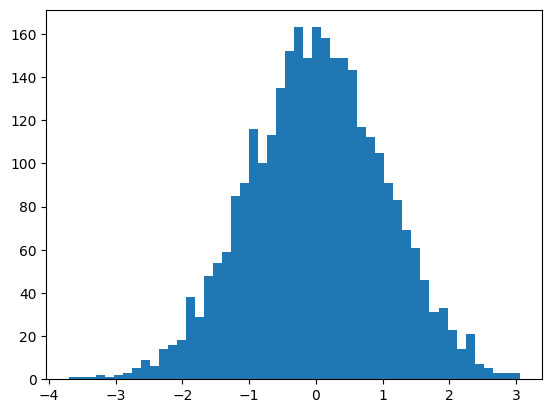

In [16]:
plt.hist([[1.0630420666552811, 0.4023540968383994, -0.2756723996338932, 1.136254455430716, 0.6005448800456549, -1.167977198516711, 0.10958943721321883, -0.834605447088929, -0.837865168998732, 0.46764840080810727, -0.013948103961815398, -1.4662712513909966, -1.2210077443157057, -1.529446676513182, -0.3695045887155658, -1.7830944587928481, 0.2467283643989353, 1.5064023774494582, 0.199166337046216, 0.12212296570569993, 0.9477999373241657, 1.2732070971439893, 0.5762305311067975, 0.07399604579671933, -1.1648402680223777, 0.2011680742551044, -0.4418091635112407, -0.07458393872379135, -1.5030568375652884, 0.31562152273754734, -0.1347926146415663, -0.17866868695237062, 0.33978684019779487, 0.6703945429370531, -1.1538681350057223, 0.1976311212392697, 0.30467712573065886, 1.3414860665493813, 0.09211748688652205, -1.2048537339843843, 0.33963902692650666, 1.07304384624834, -1.3147266627226488, -0.06995190165944487, -1.89347825357659, 0.4431344593654452, -1.0797858444472699, -0.09148056744171455, 0.9596460408776106, 0.6932552009260025, 0.20289542976248195, -1.1133273010944489, -0.3334477787580422, -0.23999782534386388, -0.5343211781831783, -0.5796664590094082, 2.309278083695828, -1.6952539489511036, -0.6224575631524719, 0.34042750846069475, 0.16431956613119775, -0.6947702846801173, -1.052531125, -0.4413781012145356, -0.026271422654441122, -0.9254631667968386, 0.6087369675841796, -1.1780510407161344, 1.0701078408645361, -0.02276835913038301, 2.423849002614877, 0.02705874403528227, -1.8307428396667293, 1.1379911126274471, 0.7190279310333576, 0.22335526260419522, 0.07669945388828073, -0.16949031598786823, 0.6816144156562702, 1.5903821464905106, 1.5065931918254447, 0.23483401606951493, -0.24647107875588753, -0.9149745488336729, 0.24325380875308478, 0.5228392610208403, 2.3415535170809023, 0.8783463492610067, 0.460841440488888, 1.2245628332438296, -1.7349814159120946, 0.37121342485155123, -0.32059221438437313, 0.30020246848630094, 0.30778401707621444, -0.0541154329785535, -0.9072379097210688, 0.9405060465120181, 1.5283399029097982, -0.1894884380981333, 0.06019484358328323, 0.2532754969415884, 1.5444298224175916, -0.25500680729946207, -0.16591412319685583, -1.183987837817059, -0.07988675029500661, 0.7716218904443976, -2.6877779265694204, 0.03235519446660261, -0.42125170280548535, 0.8549701199224569, 0.33545901423180263, -0.7699311262476725, -0.4990859622521552, 0.584887777712084, -1.377625370250987, 0.10451626166942597, 0.17612451079725716, 0.3682382378005582, -0.02388883356133406, -0.5229007537143758, -0.546437700145235, 0.8689344272463506, 0.08191735407481476, -0.5482484064181152, -2.1295699061933204, -0.03441689389966187, -0.2997238965945048, 0.19117893870719038, 2.3425659179134013, -0.7647360625893291, 0.5492678995466145, -0.10478530273023667, -1.0195890578427826, -0.007301330057569103, -1.0354867797199632, 0.24812486887719065, 0.9703284509873759, -1.2772920356239617, 1.2200813499283245, 0.5993839142392557, -0.8088717740637333, 1.4840844360132242, -0.09307884462315615, -1.1756922560852496, 0.3404800309843778, 0.37667076383261117, -0.37981672875645717, 0.21496265182937313, -0.31430088133992135, 1.0211754928748806, 0.44755813564920305, -1.8009812139068606, 0.2667340425229976, -0.14393204972738405, -0.11559444538155828, -0.6502880576225955, 1.5152629145685532, -2.575087670753546, -0.25025728264695163, -0.5208245030515376, -0.9463532834984705, 0.15548676063719213, 0.8455095653637342, -0.6287663650497769, 2.0004238970126513, -1.118012719308889, 0.8585167775798751, -0.029101528213593974, -0.07367650363943132, -0.7548158456858236, 2.6929593997440455, 0.6257130932228814, 0.16841175613039142, -0.7048880338943003, 0.0821545120244176, 1.2746532598537552, 0.7019774740360245, 0.1891115420832952, -1.5715015664847198, 0.041510210850711764, 0.8176306061883379, 0.22028247019443817, 1.8736830154635622, 0.11579298514119635, -0.09456619313570405, -0.6171987924007459, -1.126788703264674, 1.4377933625211787, 0.2983295093671194, -1.8948549540346875, 2.106220508640694, -0.392372661120379, -0.6893296053000739, -0.16112699852125384, -0.40455195774000524, 0.4267022029446655, 0.22728507670691525, 0.7179348254109578, 0.9151678105565015, -0.2505484589619384, -1.6440124642980198, 0.8289765311857579, 1.1162122737639033, 0.057047929661839226, 0.03349615204052154, -0.2871889669884295, -1.1694475060343348, -0.9802830948972272, -0.47769951653705434, -2.5690313726265233, -0.09033640675869734, 0.888207528245835, 0.5969645353444196, 0.0662731465649921, 0.4887782101760774, -0.19105837874531298, -0.9667644264339127, 1.2065869884754636, 1.6372324259515714, 0.5550878235855149, 0.6765185276323521, 0.8047561150513637, -0.3936456675230536, -0.40110925269464465, 0.8086531194315923, -0.7406483424003983, -2.78811022909058, 0.6862205910129516, 0.5349758722199042, 1.562442167507185, -2.513008730073358, -1.0247501026640133, -0.6646010384698308, -1.0896091881924457, 0.9220805608400061, 0.5923522494763039, -0.1404321744381057, 1.2684021404013084, 0.3333827308890619, -0.8108398663890539, -0.4953779130395026, -0.7931616480204723, -0.5844135992539979, 1.3050397375992178, -0.5221785563029597, -1.0036833172693378, 0.5894530490921086, -0.9320892151246065, 1.1786628628576428, -1.1977663858373098, -0.21669621106066528, 0.35900626316271317, 0.5412178090482029, 1.7237821986753492, -0.9764132912699361, 1.9488034754046664, -0.41656153263406737, -0.7401424277876829, -1.0966546801464743, -0.18561108374759228, -1.0696244466895366, 0.25166752838430123, 2.367971081532085, -0.5454182371894574, 0.16070557151713502, 0.8411337106800822, 1.6144831547027354, 0.3765491515917981, 0.5656656684918877, 0.7477755614052518, 0.7720092619444869, 0.8874932775770128, 1.6450925876272278, -0.5467828087160881, 0.7061774803089739, -0.4965271937186917, -0.5568909179319449, 0.3142297876147243, -1.0358441257742654, 0.1596731761714098, 1.2868745782348359, 2.015349289747565, -0.5707428962428648, -0.5335021124687679, 0.42207815604029475, -0.1669156724189436, -0.9113592440249226, -0.41224255398798915, 0.412631565664723, 1.371139437004212, -0.06761716426322989, -0.5996476587256031, 0.8265575062546259, -0.45867312742143435, -1.2555797359109069, -1.3416725127658802, -0.422066103873513, -0.43903645062887114, 0.6925726614295821, -1.2211598578322356, -0.9053764202088024, -1.152317477977151, -1.0395562697341025, -0.8088526987907704, -0.2030190071234487, -0.09325988312256014, 1.68811749447304, 1.3296745709401498, -0.38902635104701055, 0.748078599133911, -3.374835362307459, 0.8015738016660522, -0.29656048600004065, -2.26451614821168, 0.7842407930260664, 1.652932850261434, 0.1831598118509347, -0.4299936676085056, -0.9300112034667956, 0.9279242870611536, 0.4236717655402744, -0.7306567357191565, -0.4574615701967178, -0.3149004796071284, 1.2055618978784248, 0.5524576369089992, -1.3175491513995954, 0.6596171689828937, 1.180720127382685, -0.2813769431100532, 0.3274641612209175, -0.16348073496955426, 1.2605955152675368, 1.5839597648130521, 0.43132042592975295, -0.6434575273141343, -0.6067315100463405, -1.330837483701877, 0.7365816805111379, -1.4323721209805256, -1.505852168560387, 0.5825336288058007, -0.6541131114644636, 0.9896465494765232, -0.4907840600688514, 1.5976978254380374, 0.4203643953830333, 0.9630754186554771, 0.9653407993559466, -2.6807908973023786, 0.01593551224915517, -1.2005687652624217, -0.19194687811872055, -0.16469738592592623, 0.588653474610213, 0.09513988611947807, -0.009187144109534754, 0.8768605746009601, 0.17882450591447205, -0.39354925381070854, 0.6935316588613415, -0.30354635929824286, -1.4222315248095532, -0.03874374214477885, 1.8883871418635527, 0.8342281224917881, 1.9176177014532871, 1.2597651195110633, 1.3147539972720457, 0.4375828994926511, -0.26548361065450504, -0.027433404369327296, -0.17296127228400562, -1.2140682863466308, 1.8084803689332827, 0.7620442289897744, 0.5913189303630006, -0.8732737619226432, -0.22636114453472808, 1.0037454003395816, -0.2039942194219014, 0.1474966130063291, -1.9754547411667667, 0.5815307937135379, 0.3535252309776394, -0.5648331334836912, 1.275279811408645, -0.45664412864895826, 1.8963080007436515, 1.6459909951642413, 2.2003037538296764, 1.1707935075401241, -1.4484717266122022, 0.3549360812628675, -0.747173585824435, -0.049133110871938473, -0.4786862670051759, 1.0097659508968215, -0.40744643179216194, 0.15621028753338959, -1.875466583032947, -0.24471977388727637, 0.2455291705783266, -0.35687125338343884, -1.8959760273603727, 0.3591081943869144, 0.5259512335037569, 1.2009705743351402, -0.23011557219224174, 0.12466161440470055, -0.7894114801918573, -0.6403671768270905, 1.0070522914485935, -0.07871981372347427, -0.5579978298779853, 0.5159258379214923, 0.2647485773630461, 0.29470934580177316, 0.08397918681879861, 0.4038098347176103, -0.27579729752884197, -0.17431603487199737, 0.7458544156781967, 0.45958739804198584, -0.023969790399143848, 0.33380814823776983, 0.5367756275757501, 0.6537222308001278, -0.7538404243582574, 1.5280530941308264, -0.6285622392541977, 1.7160667948491257, 0.041210471927656124, 0.41034664199499177, -0.05347093452639781, 0.44096366275131077, 0.2537412815361652, 1.4816150507438033, 1.694727673260829, -0.9081117718333688, 1.4373241979445106, -0.1592591199853857, 0.2273581677228073, -1.4966270582073065, 1.659906784299086, 0.4070520682417559, 1.370809659426609, 0.6991668357057711, 0.3926928546825316, 1.2744695304423388, 0.5976978626715289, -0.035537378635795785, -2.3382323458902587, 0.9248292067924093, 0.19372918223581817, -0.6289069529756416, -1.2080845744647102, 0.012221284732773518, 1.1844605929311403, 0.28305513384962405, -0.4525658388359907, 0.06469155241570046, 1.6926462861897378, 0.2455124094123435, 0.9001943104398317, -0.7830800956194606, -0.9290194548234769, 2.258150270342442, 1.7710875940979884, -0.6334399076834422, -1.146067586395226, 0.5017906081776641, 0.8560467846291236, -0.6104785446749008, 0.5573174889685857, -0.9837997702689283, 0.7460861318044281, -0.5880981847406999, -0.9020909792662225, -0.6120762729823377, -0.48511396502098547, -0.659570828478812, -0.8305247942997376, 1.3550897924835497, 0.9450343443944015, 0.6709457504504691, 1.1340042711225424, 1.7656607553216328, -0.1924088076691858, -0.7422674244181175, 0.6045954995151767, 0.36224928334389855, 1.1099600120598594, -0.3605731035678844, 1.4839990288221518, -1.8035962006925528, 0.19987913081712605, 2.163142749832099, 0.90279549539423, -0.7435405927295333, -0.028565556521929204, -1.0803004725158125, 0.5316124882464623, 0.17637949440785533, 1.0928252875677433, -0.4729408954718643, -1.0542172102607419, -0.36828950676792216, 0.8579788833500678, -0.5418793599408839, 0.6670005027918655, -0.5361391704229077, -0.8524028913107912, 0.9616109551717226, 0.6154209936359816, 0.36344516771877755, -0.6219389313070969, -1.742607003007853, 1.1697390185141499, 0.6170215302764258, -2.039286999270459, 0.32667527828027443, 1.1802077440110972, 0.8697029297977881, -1.0266067947292075, -1.3445287127561165, 0.6501791936253797, 0.7010844523537486, -1.6113000057780922, 0.183561562851014, -0.2696562850303232, -3.1144388875928524, 1.1271439409468502, 0.910229878063614, -0.05684652893033952, -0.1284306697664414, -0.9557105477534659, -0.20629158647916143, 1.1322325462497318, -1.6360367569607304, -2.152260749777835, 1.9794898444726474, -1.3771212072963062, -0.2938104142984543, -1.5255891261965557, -0.6961451109007885, -0.299574858907886, 0.1550406122712836, 0.3744896859655533, 0.014415148398526829, -0.17961595910971678, 0.6282041149824793, 1.6367322833839482, 0.06162310272289247, -0.0945635624152488, -0.6498893770052364, -0.24831150472832003, -1.0519292027864122, 2.234250876815806, 1.720501960107123, -0.36887540515255235, 0.4159383401859368, 0.48087002612457996, 0.2819332572709211, -1.1535041427707686, 0.6587370983494082, -0.2565886810808135, 1.9647806832387047, -1.1194168206151434, 0.002874072937340238, -0.7988167357939588, 1.960697804482634, 0.29789385925058764, -0.8880807029528652, 0.6513680596364972, -0.12069197994719082, 0.31708331693247904, -0.6894239029836263, 0.5322312108135506, -0.06570608926245246, -1.2648226897600041, 0.3658476427654977, 0.1318527232781678, 0.6937192273847622, 1.563526664845291, -1.3098194699974814, -1.3402434887141588, 1.7033996184381257, -0.13014479371071003, -1.5226374464044847, 0.7338327363991668, -1.5560410820273627, -2.1822541909851427, 0.6612284029023834, 0.5088311875652974, -0.05000291103264312, -1.1054438744707418, 1.0966646398133477, -0.23101577012690278, -0.8458096243764172, 0.6678301871516922, 0.19097819690036744, -1.4011642865635892, 1.0741813489756773, -0.9480835609821331, 0.42077144661734955, -1.0940611044767428, 0.18522983053805414, -0.5602355304834447, 0.3976571647825049, 1.146158081864533, -0.0530862812364095, 1.5432482635737366, 0.46633731154240726, 1.3868090394867316, 0.3784114975647055, 0.9744386737278282, 2.0351798523405846, 0.11813543675720915, 0.7584503280981597, -1.2879145902346645, -1.2750151650517156, 1.2468111709494643, 0.8685785898806223, -0.42683960980449787, -0.02187374687685485, -0.4096242902223326, -0.40425103240839877, -1.6600696997020847, -0.05286364429169171, -0.34424641015409785, 1.3070429400696315, -0.4579516647453818, -0.4126606647840995, -0.8314541514682243, 0.7448506800061515, -0.709836866254489, 0.7259639607013928, 0.377765961082715, -0.2163678108426498, 1.3105921252596717, 1.464878228558219, -1.2244367870623458, -0.32939249820085764, -0.49057751798737975, -1.329344979212545, -0.15692954569952097, -0.173295108182508, 1.9826595782747982, 0.5693671169583278, 1.4999316520543922, 1.842329484137073, -0.16085298647734111, 0.5194753226613666, -1.8314539016338467, -1.5937476218633966, 0.1752645003967367, -0.3712597460978008, -1.6177377453949182, 1.011083293782322, 1.384701813798464, 1.4764247126557444, 0.029401706308592276, 0.9083554420456653, -2.0822186388022708, 0.308764589260418, -0.6753594364266724, 0.026249285556881427, -0.7779492883241714, 0.018676089080355673, -0.200646439957614, -0.1282961504366466, -1.309505134616867, 0.5805769181828851, 0.728018610328815, -0.17599781892507038, 0.50662886805737, 0.9205430523886659, 0.9117847207314935, 0.08697610513474321, 0.6280176603851032, -0.04113445368557684, 0.5463675525437732, -0.07906380110387348, -0.20005743231474699, -0.28415558923678563, 0.8557924650422303, 0.37117603972784596, 1.0404655426706186, 2.4199321036221844, 3.022035779151513, -0.7647845058653295, 0.3280300400619968, -0.11949372825167077, 1.2720015466923533, -0.1558500700961065, 0.022981588532489015, 0.7054150969241663, 0.3598335480443534, -0.44780806400120765, 0.3229385721659978, 2.311547237992894, 0.34930227387475304, 0.8301991809051801, 0.8611722607999901, 0.2843018861244314, -1.9047218894832532, -0.844915628469998, 0.1493864156548584, 1.3587372042129364, 0.2259552450990039, -0.28764459506207257, -0.74996248442769, 0.05894552311926838, 0.8568199613523025, -0.39123667724755756, -0.07679477445545602, 0.13709289017974727, 1.6554444845958387, -1.0070240172477334, 1.8113907407916996, 0.2821279007980289, -2.5885163824831867, -1.0542663075145364, -1.7682228942043656, 0.22382089879698383, -1.9400326368777758, 0.24304193863397242, -0.9124847079669839, -0.24088399157614135, 1.108424525058825, 1.2575728575875442, -0.6246478809750642, -1.4855540546299044, -0.2720686379803629, 0.010997941055997012, -0.8148106910104843, 0.6766231667960683, 2.268567319653223, 0.22728189012943834, -0.07976227115014499, 0.5300032094814902, -1.496305867275841, 0.5086197184445195, 2.089156267634884, -1.5677711247944428, 1.3288968043629306, 0.35471765757708007, -0.9318237215604146, -1.0030491838616367, 0.9757810124033747, -0.20913856422551252, 1.5840269135993494, -1.267472597878476, 2.4428795458150145, 1.2180116606214848, -0.025705763653205073, 0.813145894724438, -0.5193456801008562, 0.3704154645804545, 0.19471889901168465, 0.625589945972739, 1.3293283354364944, 1.087551072032136, -0.7884336507777568, 1.2755041998644565, 0.01379496591642917, 0.1262545159867424, -0.43783664880575734, -0.6065018981086864, -0.7399931681105012, 0.4357136035650332, 0.1495307858599888, -0.6514001780996337, 1.8261446224844833, 0.9858497723629751, -0.729803429786005, 0.5866380674005248, -1.5846627013837056, 0.3443564048095056, -0.5099452340923352, -1.9422927545227209, -0.4692543865618847, 1.2957531039651233, 2.871214944514938, 0.645573942101128, 1.8064169307969726, 1.1221620415245452, -0.5494470403090109, 0.44908332000017104, -0.3528975523831406, -0.3361226751706303, -0.8154077050053347, 0.041170371942369964, -1.2899459412640157, 0.0773153951979279, 0.7383048129763944, 0.5284006440392065, 1.028516450395663, -0.9302002371762511, 0.9565251204131716, 0.7301176475392261, 1.1658271942718235, 0.8036868709571672, 0.9591295172691894, -1.4674408933084537, 1.322068438481858, -0.4630611267316578, 0.621414555501673, 1.9597658183945086, -0.5517984945683155, -0.7890521983929921, -0.5291579229883611, 0.3405554735317706, -0.5961345307006518, -0.5607324424994328, -0.22601889076877726, -1.6247039872667068, 1.6980932642332813, -1.1821569920294812, 1.091459202302908, -0.6594149427286154, 1.3706336695955623, -0.6873088082536917, -0.7627601388838948, -0.5547270101982413, 0.4745501045112488, 0.05882606994153849, -0.8707681453394915, 1.2398949861431259, -0.6957660186322498, 0.3872982352990979, -0.2250584694206054, 0.6694152607116264, -1.2754897958694953, -0.05137225346206762, 0.35038688349861646, 0.8152958774516241, -1.863133251389882, 0.6927942703392937, -0.4104549213886599, 1.1236448497725406, -0.9052880964086003, 1.1015225607474635, -0.03550577933050288, -0.1507075953965139, -1.259970655005296, 0.029722069118300755, 0.7289648825351387, 0.7804472369053597, -1.176072763037194, 0.6246881512992335, -1.1024628939647678, -0.2458699426334497, 0.05945774622436853, 0.7245879299550977, 0.30453417036710034, 0.0905522391073852, 0.4317261579740929, -0.6992012187047331, -0.8580327014317988, 0.3226339701206081, -2.093067654791185, -0.9978311703094936, -0.1248875715646379, -1.0494525399661156, -0.6295890629759675, -1.73288954824096, -0.4796836372244844, -0.1926287466374542, 0.9420693896043453, 1.5877372777117567, 0.5360234555902978, -2.5717077582659464, -0.9739919951156585, -0.4173835023389228, 0.4583598770511894, 0.7904571803284988, -0.11279653974356962, -0.9968678646138385, 0.991519532259376, 0.11947152608594996, 0.0023660698464073077, 0.12244506930956472, 0.11507761934762661, 0.7107122320024466, -0.9702950109551248, 0.542293515816462, 0.4410864623398642, -1.007885412218117, -0.04346894090921395, -0.30298616404146617, 1.060567748415289, -0.04299400381547501, 0.5814222498009093, -1.6224637909136386, 0.46010074942204027, -0.5026276424674136, 0.7430461922095267, 0.9330359846080408, -0.8328561003698858, 1.3142779598559375, 1.4292396869926414, 1.5682332705258173, -0.9902658241754358, 0.7173431349082925, -0.04727292510717265, 1.3819543225799547, -0.9896043816137353, -0.04182390676916829, -0.7410486244343252, -1.3749981222396732, -1.0389225182818567, -0.29950312213435215, 0.05659451339450302, 0.5703941351632682, -0.8277531857495134, -0.17245498368619325, -1.4185611915484588, 1.1929197309350152, 1.0042906334896504, -2.1064178529600235, 1.1728472238122654, -1.3826101733009868, -0.8924019536989711, -0.5563641422043337, 0.9826722790727754, -0.7758144960653738, -1.028247527107176, -0.008027078739161732, 0.10977342262830116, 0.832804277319576, 1.375088138712443, -1.0376670919954483, 0.35484077767742994, 0.992022108045153, 1.5362321985595913, -0.6735871589044037, 0.3900291553797037, 1.2014329315693972, -1.157446738721231, 0.10661019160137988, 0.19032524904595272, 2.291530576698424, 0.9363475169404655, 0.5269054207149908, 0.9984075289883197, -2.6844987190492104, 2.070562738646089, -1.2393084802915029, -2.1329657689987354, 0.3639296532998505, 1.247196744026315, -0.2775765518092088, 0.43954101576470656, -0.9857626687444901, -1.632818941548815, -0.41506797670288387, 0.03364471566384496, 0.06321829841717196, -0.9743733740700622, -0.6094444705437784, 1.0546212735111014, 0.7678404466309161, 0.6875607492135777, 1.1124982931682708, -0.11301867970894738, 0.9068388269464926, 0.14703428422627918, 0.4966264193329309, 0.3218738206975172, -0.10768642203071178, 0.5505809793261585, 0.5930534606866242, -0.25519742419726726, 1.1279370681489913, -0.26891137658927167, -0.3209581131534842, 0.6321558359699613, 2.330864048638384, -1.3920310860080198, 1.2448467213185501, -0.43400683321397227, -0.10253422614178509, 0.3413543096533486, -0.8757661199507016, 0.40432025910455577, 0.5725090261224322, 0.7748918918415513, -1.260390578348668, -1.278045137614464, 0.7977738117863151, -2.345728969322607, -1.1488205963446199, 0.3485747846419069, 1.8422423269197494, 0.6562499005935097, 0.7073499738712344, -1.7730090875807918, -1.0714579124290011, -0.9919870782056727, -2.591354490276577, 2.146693810621565, 2.3043931516450216, -0.829905044248389, 0.3729888662013551, -0.006303708553015787, 0.06182034712820671, 0.42500708503335927, 0.46078963426885844, -0.3804355928389798, 0.43986530791939, 1.6565394980644976, 0.21081504662099126, -0.3805044615189674, -0.5903799286532592, -0.5098058772138134, 1.2556434437026212, 0.4329529144724273, -0.8784243210436197, -1.497284006424722, 0.02913046929628346, -0.9545951392014502, 1.2921136168995682, 0.9253057334004587, 0.0897371275421883, 0.32670800796522953, -2.1557796480314186, -0.09407878249179104, 0.09013327851638468, -0.25274170768466103, 0.7709247473571291, -1.2218984859973008, -0.3199218471174386, -0.4195242443437222, -0.1578408221484022, -0.929599128755531, -0.9164889597506813, -1.808780822904162, -0.42662626684430427, -0.681940162084538, -0.6943384391696543, -0.6811227022436765, 0.909509174526067, -1.94786812215052, 0.7448383380737527, -0.06711330756727489, 0.38955497095242336, 1.4660036015747993, 0.04290429628218573, 0.3264371289344428, -1.4652984455636253, 1.2138653324582065, 0.7573356156061726, 1.0747116447932181, -0.38841363863446476, 0.1994575858263942, -0.3874923324105858, 0.5276016191796826, -0.6560523812442526, -0.11968714500485778, 1.2637565922052638, 0.38464643206149873, 0.05864463630576964, 1.0581576301236906, -1.2264189759390214, -0.6370901883539855, 1.2108369771923675, -1.7024159651050028, -0.06446111445589242, 0.48589495486465856, -0.5864063231819925, -1.6498570762189968, 0.5737964665094717, 0.5803692987715852, 0.08786803781008846, 0.2949856651309995, 0.30744493746442164, 0.6338884081092311, 2.149976610891275, -0.24406411364494104, -0.3994568316284333, -1.628504290945497, -1.3578862337169777, -0.2064903200662313, 0.5828069706039671, -1.3598928332764337, -0.906184860189513, -0.7165027294318065, -0.9655354293827652, -0.3951891804895168, -1.7265099836510505, 0.27069754871352264, -0.9548252033452812, -0.12705005012666595, -0.11941559522684067, -0.006571529731845489, -1.1641534309207684, -1.5579977891941164, -1.0672149517365728, 1.794636034382996, -1.4832037659306812, 0.39280424534458364, -0.37124510931962834, 1.2986218448334585, -0.21831881811501988, 0.6333637930299565, 0.76314878964738, -0.3818032156960683, -1.1497925022939945, 0.39991997131802637, -0.25389680271250137, 1.8881485886859044, -0.3705615349327398, 1.175884635795603, -1.3363122271190968, 0.13911410536720953, 1.719669387755322, 0.14495855274244304, -0.49867033109962144, -1.0192590908243109, -1.0834854684940882, 1.4404328217783446, -0.683775277906805, 0.3207492520962722, 1.4831423028467663, -0.26295158720455014, 1.0228333918724, 0.2448298700841628, 0.03450389090473252, -1.9221942094480862, -0.2575685887521646, 1.519446911254726, -0.06409600292941661, 0.5720528258842551, -0.29269686665453637, -0.44796979371302237, 1.0009543366069211, -0.1687200871514738, -0.15286469846086587, 0.18927466689406955, -1.200144058119418, 0.37220183486953146, -0.48937514966043605, -0.1220350590832771, -0.5347039400477714, -0.9747235698251367, 1.181145923271132, -0.26133016741331794, 1.4828556461506466, 0.11321589687742238, -0.7140462674427527, -0.033000253446450474, -0.9914181862043121, -0.309707322638234, -1.0647542085609676, -1.2580979103812495, -0.7624810113393302, -1.5137691369945336, -1.2353666261720353, -0.03631673925834414, -0.19932954548403342, 1.8551697819026312, 0.18747998381119982, -0.4766161636228397, 0.0018582001860513973, -0.24469396726912454, -0.13700766856530752, -1.3011348989741627, 1.8877447245211323, -0.18131349533769783, -0.8509634530698238, -1.1797363581234044, 0.3065722284349592, -0.25978719198928646, 0.41887359741429664, -0.39849165815255383, -0.15517139991307421, -0.6272057604717093, 0.2907767258955339, -1.5357590339434626, 0.005257281066041783, -0.7638486204432559, 0.27058078531155183, 0.4337529551195338, -0.12394230130227699, -0.6743571873625457, 0.8246520793934721, 0.7630079431067952, -1.5395221978886109, -0.01565791178688936, -0.33105769320423295, 0.5138306078836393, -1.2351240687097618, -1.9425556072757888, -0.5381441111372544, -1.9175831007275326, -0.027243126536560996, 1.0549288439578788, -0.2698274156802986, -3.1988432421789423, 0.5393731945562468, -0.02692393612976111, 0.9991175215161865, 0.11297331928021666, -0.31752116789971446, 0.868073030984538, 0.7774006934218353, -0.3422455791059716, 0.3551373557064538, -0.06445304055045173, -1.8325988262090407, 0.8993032258501079, 0.4462041696398148, -0.8957189318404317, 0.3208105725560852, -0.3303068223298009, -1.3609580927415628, -0.8428152010707137, -1.5405466601822186, -0.4768270688750923, -0.5964431899264585, 0.6265675029898384, -0.8087153301343184, -0.17094415135178478, 0.3912393588985341, -2.5020060177531125, 0.8205751871777249, -0.45805228152252375, -1.3693261089439852, 1.059350464916235, 0.037694736797466634, 0.0767050382681828, 0.25192745257039045, -0.2702827061005173, -0.6226254649889859, -0.27171826213542766, -0.8362380117080993, -1.5881534965943316, -0.12466220262500372, -0.38236842575212343, -0.12272240426137067, -1.8598433685135372, -0.4385182875330333, 0.13023454383104582, 0.247579852324281, -0.6318855690577303, -0.15599399752122672, 1.3449344382515824, 1.3714427995994263, -0.2588368023526445, 1.2248015610420282, 1.2446612182176167, 0.2271545798355823, -1.3828597635899937, 1.4288581276047465, 1.7054502364343023, 0.562292150987199, 0.9616342653026371, 1.1325754919793674, -1.8969795093558233, -1.8528696666304985, 1.799189816878293, -0.06961004921260758, -0.7277270254848942, -0.48884748186279836, 1.459010926450895, 0.7129915883816486, 1.5530947376403612, 0.0689370868692765, -0.6694780024313708, 2.248247577939481, -0.759753011991762, -1.0400999522112482, 0.10434800384671995, 0.45094798093657334, 0.7705340521668949, -0.15637022060678962, 0.7537670321205098, 0.10763992102205892, -0.798687091690867, 1.4983377309185315, -0.33574903567200065, -1.8864092406237212, -0.3573094410164495, -0.28457998742012314, -0.1741013461224939, -0.0952942533809817, -1.3498268570463874, 1.465926924279219, 0.9064662985212308, 1.537580979821559, 0.13386682623111285, 1.7339012732568297, 0.20616869154131418, 0.32211981930340755, 0.15722213050269715, 0.7535965209751122, 1.0123361785489633, -1.3733044052793704, 1.7747163319728443, -0.9495984554916967, 1.9084857304471292, 0.3975015972694797, -0.2683850065657522, 1.3806595146903415, 0.3293211170117504, 0.9267010395680786, -0.33432333148570326, 1.484806902230691, -1.0071587193726137, -0.49224379766670767, 1.3778848914485287, 2.397885575643835, -0.5628540866732205, 1.4531059949382765, 0.3584557776449882, -0.8273733526686431, 0.3708434396492865, 0.17042045416320162, -1.5553667514791278, -0.699942214311986, -1.4718451646872939, -0.6038813984733669, 0.6957340557615107, 0.297656548147246, 1.723113371372594, -1.1830730568355625, 1.247179940746063, -0.36357714953585, -1.1188118482853846, -0.5293658344520937, 0.42739638330915974, 0.9501138951409136, 0.11564222640466047, 0.2795461044516718, -0.47223177725125176, 0.6095153381759323, 0.6338688968583444, -1.4448526811646405, 1.1381470436816676, 0.05738090642030633, 1.834887913647572, 1.0084429738618201, 1.3241807350845927, -0.689638843756055, 2.274749521873628, -0.010764332346080601, 1.2147153019120496, -0.25481384699947923, 1.4740035304602097, 1.4809435229287742, -0.5186197219538422, -0.5604258724876312, 1.0114053945121433, -0.9836667818897245, 0.7661341624688549, -0.3604878052341167, 0.98993415120748, -0.6209560130634503, 0.3900077159565838, 1.975088955009941, -0.41936202562313935, 0.8968612181943999, -0.09062900286701656, 1.222237122803273, -1.9324068909918672, 1.0860671811481122, -1.7049206776468275, 0.2047089594474463, -0.13939801727944054, 2.213701324753993, -0.9465296217637389, 0.4280964267149463, 0.36545997352129883, 2.1173639250190135, -0.010043446335811274, -0.38959547883396256, -0.838468344179599, -1.20360046592328, -1.5704291420221637, 1.0586856612344246, 0.9796058511913667, 0.9477488280056939, 2.221750392075075, 1.2179301374001552, -1.1793256675494506, -2.457620224451549, -1.2652966034883895, -0.8265828369473965, 0.8283090453304202, -0.9828683237540528, -0.6803527582742513, -0.5544795840624142, -0.3397403740330953, -1.5829364661343603, 0.6551702073392135, -0.5391931628856264, -0.5441498897380671, 0.20348530705014853, 0.8012097329751645, 1.3917549910989746, -0.543400783567624, 0.2837811183766692, 0.657731625658846, 0.5326791141777281, -1.448322915444958, 0.3563314424711264, -2.271127820843662, -1.962845334848823, -0.21719669806748507, -2.1427434523968563, -1.615496028341198, 1.2413180308395475, -0.12787903157671968, -0.18408298048922642, 0.16218028573761728, 1.3680145920943954, 2.5428928119638363, 1.3570374019921276, 2.2616639824937286, -0.9969167456048563, -0.7736613948096936, -0.27318209673778343, 0.2793780385499584, 0.47335572877944515, -0.789234290175374, -0.5315131675054731, 0.7219134382598917, -0.5283522869417001, -0.16136876181888313, -0.05986147880946239, -0.6691900340852374, -0.3705561130195342, 1.6829077483269166, 0.3604364296026986, -1.7565111774370343, -0.6700490323626198, 1.4593078684883718, -0.883714777797362, 1.0605449682700774, -0.5941908984999155, -1.4273999315983257, 0.2977910458408504, 0.9654045049236557, 0.1564210553854383, -0.24989382402000665, 0.6021396320186387, -0.07372461981084559, -1.0483502999875982, 0.73459213090449, -0.1766473098993614, 0.6983851414300918, 0.0919657685510714, -1.2929010709662645, 1.6339656078768574, 1.3508676426933697, -0.21338702304165366, 1.8863467770339266, 1.1136649100850489, -0.9536243477549118, 0.11277443857673507, 0.15158023239651208, -1.4526239401478518, -0.7329313541289855, 1.0600709128826464, 1.3159144558463034, -0.8003790604410508, -1.692492405938005, -0.23857656665394336, -1.927072942976767, 1.0438114396895013, 0.15736903423840906, -0.5243909022177555, -0.608852577234388, 0.8846223883372011, 0.6302091737610794, 1.008121621864493, -0.05842529221897871, 1.5803081292541876, 0.5786961408887393, -0.40313410312100945, -0.6189317695276799, 0.05392871962725726, 0.7579961948273795, 0.7138519758882128, 0.19508708718235446, 0.29721868225144715, -0.7654934601486323, -1.086162348422033, -1.2473941515169906, 1.429748997988486, 1.482518988258252, -1.1503567886086485, -1.119614990817783, 0.7585186991884231, 1.90738143512488, -0.08032802626003224, -0.9961960197698773, 1.5723320130233873, -0.27178442749753234, -0.3397549084196784, -0.8150055035107612, -1.1952633850151806, 0.39348417755131826, 0.7038474097559088, 0.415933637308906, -2.4209769354823285, 1.1128463499933041, 1.3142974329025785, 0.058464850564335, -0.08993764041333638, 0.6440275825368399, 1.2777456305876362, 0.38219843482820426, 1.591006976513316, -2.2984523083533612, 0.5462680923109693, -1.3555546492244384, 2.093002572622018, -0.9341645335352284, -0.008558238635116015, 0.36270154567742874, 1.1251124414759985, 1.8252596738336506, -0.44104741376997547, 1.0559731972811506, 0.821099035398127, 0.3392188840464222, -0.5260893483278963, -1.0753401689577065, -0.7474587551582755, -1.8078076006750103, 0.13672333078510632, -0.964878020526171, -0.7464398126453463, 0.35946381302783276, 0.6059082159865962, 1.6858988093763723, 1.7529292996938692, 1.8560169200452066, -0.8675550434795075, -0.1280740098258184, 0.2909119830143892, -1.0092579317596313, 1.2912513050172694, 1.2460806074235498, -1.3056958938771843, 2.0670033001420194, -0.4287341399021851, -1.5708545988301303, -0.9922569976601185, -0.393111665598689, 0.4424818340112588, -1.2291015801171574, 1.59844452254182, -0.34652805023107697, 0.740642545357245, -2.903586213339145, -0.09205758012175289, -1.022714308172678, 0.32535234939613233, 0.6054614536686619, -0.8186604023625378, 1.4782158577975322, 0.6295667733341983, 1.2108638778096714, 0.22286078142698723, -0.8257853716892787, 1.1197437884396617, -0.4481932152519354, 0.4751415660925263, -1.3510441261023591, 0.7930387607182223, 0.41914137153406883, 1.0375802024161322, -0.11930186718027844, 0.9700706897018433, -0.5257970814836762, -1.3319249296475355, 1.9486803448705852, -0.6599324120005072, -0.7002127833933789, 1.5757331366565173, -0.8977064858894267, -1.7136281763648544, -0.2074830760835804, 0.9576497069569613, -1.2494728416923109, 0.5441948255265413, 1.0546238434355673, 1.5373883443429415, -0.4424663487465237, -1.3125710271646323, -0.453728511543651, 0.811064621737429, -0.9840462967338602, -1.1980379017522027, -1.240397359605888, 0.18721534045513097, -2.6352507026013616, -0.6744371136237696, 1.3985552347116996, -0.1575579903096871, -0.4383321881772299, -2.056721908991496, -2.1910333908660413, -0.92665879011366, -0.8993692834874768, 0.8067789950513143, -0.5576363820842486, 0.1539582544861131, -1.251826635828526, 0.33200728210173713, 1.3291601750230198, -0.20564723885552888, -0.20412425572993476, 0.8691485581976655, -2.1378365705941826, 0.5210880310529454, 1.4416460854870465, -2.0317961349354405, 1.0377918367538919, 0.3160837841109393, 1.4614158180652976, 1.181252318256251, 0.8407406980010619, -1.924289018591829, -1.4203710498263231, -2.410612736359848, -0.5657802405682112, -1.1956124459779969, 0.5683983012199285, 0.4821784625157513, 2.354720320340903, 0.6187280736281123, -0.5870670240793426, -0.2953501658116161, -0.9856189695544346, -2.072294362812869, -2.308962321486933, 1.0849044618480839, 0.7933399798765861, -0.24877943268960445, -0.23363625036000224, -0.4241626973346638, 0.12090258943225687, 0.013043372895154793, 1.1042230117255356, -2.059253297095632, -1.5420101681713327, -0.5473829109896132, -0.06610599557550398, -1.2690495509208162, -1.1763622361172792, 1.9767368742572298, -1.018796132369791, 1.1393553851790914, 1.47843686316299, -0.8285091304257857, -0.2579248834874646, 0.3075933047793649, 2.541594779529243, -1.6438378455400606, -0.3044773685931527, -1.6437042981000762, 0.19423474988638445, -1.0455892302981895, -0.5994827647932777, 1.3168424796691534, -0.9872897108830545, -1.6805687030698153, -2.1196811463445946, -0.7591236975314531, 0.8335643862261934, 0.9921618658325527, 0.2377946469811807, 1.2182125697069417, 0.8771104179930981, -0.6248030860183712, 0.4286173060139395, 1.564557397582906, 0.4288804006366851, 2.0484470864446003, 1.2308401230908212, 0.4045021107877746, 0.30195571629471285, -0.1875585315311612, 0.2459526617482749, -1.8569996503494366, 1.2698528765065265, 0.23244810922088668, 2.5271202533948296, -0.6391232360296477, 0.2893577196548196, 2.0099303333368916, -0.8106749796951742, -0.6160480208005676, 1.0498970274741644, 1.9774746276612465, 0.9260516421714038, -0.3511081609700675, -0.02898770993413513, -1.2632879707868758, -0.023978317609061436, -0.03790842913148948, 1.267699015136461, 1.5502796812630644, -1.1280579672404583, 0.9972295181337432, -0.5781934498870483, 0.6228005865235994, 0.7803232864473156, -1.9889682680597107, -0.9573531577175324, -1.39436067109835, -0.5198611224375103, 0.21736217874569377, -0.38384538513548805, -0.7944522658386425, 0.028423393656276767, -0.027209640831067784, 0.8543462058092841, -0.5392365158377136, -0.07196342718074061, -1.072150069613392, -1.0445804450097569, -0.9235520307102225, -1.2617557097493566, -1.4972489183591362, -0.8706307901831141, -0.44298267915073, 0.8053488918982528, -0.5969788967792484, 1.3305994609815248, -0.34946831871938394, -1.2690088985595098, 0.534208957222893, 0.020019257192151026, -0.536229322323906, 0.25928020972587745, 0.9602301786814229, 2.232180708460417, -2.0689126173889534, 0.5483965353685482, 0.9540202460808813, -0.21433932980545475, -0.0683836449311519, 1.2026655025506525, -0.48437829896759965, 0.3521449445724512, -1.8596888805599971, 0.7739674366717197, -1.8973106455203346, -1.0141281465862189, 0.7700422751247104, 0.2579976209239653, -1.5382515316753738, 0.14350519617132368, -0.23245052868550642, -0.14709727995037025, -0.46297518142841926, 0.039895084917001826, 1.106319530181078, -0.46856749426804195, 0.42539376046737726, -1.0242514409889985, -0.34287304219794557, 0.7169156148649114, 1.4277334156712476, 0.397468465447774, 0.9609062513662825, 0.8944755395900212, -0.2533984425676617, 0.8328389955269618, -1.6630708577562527, 0.4986040704781512, -0.41510957289380784, -1.3586154994261188, -0.2575507718878851, -1.138961345929818, 0.45332413974545127, -1.0721604302322818, -1.2437801072834875, -1.7212043377766624, -0.018230031689741032, 1.697515289484102, 1.0849919760770226, 1.159129708018443, 1.6973514156922893, 0.5059165219854871, -0.5867017416921091, 2.375423686936571, 0.9750504284478763, -1.5899563309266334, -0.4106479063779228, -1.2700479893432124, -0.9198273761604631, -0.02762909231343373, 2.9257435960628357, 1.2545945752762846, 2.123457506574295, 0.4309783044013187, -1.1103096047124752, 0.07406469356015352, 0.7487506671515276, -0.04352087189365015, 0.37498660054319005, -0.23901006917488662, -1.0470654731126336, 0.6593790665542358, -0.5324193919320729, 0.5057498829164192, -1.4880823788663908, -0.012580288482682308, -1.220105503900401, 0.3146716304364215, 1.6842856960286843, -1.3758741098049223, 0.09974455892038249, -1.4787154917579661, 1.9418761532043727, -1.5546731390096689, 1.726048463646208, 0.1111499744900181, 1.8511117488176363, -0.9204496414655484, 0.7457237102602272, 0.5576779070154169, 0.7819097180689353, -0.17285704162508023, -1.4657857351767936, -0.4473825629774739, 0.1956328408265915, -0.1876585589512063, 0.02175242659102131, 1.6438919323652197, -3.702755631221805, -1.5056513491717416, -1.6687389818500653, -0.18910207533112253, 1.4470315583175715, 0.8052460687895695, -0.23222882719044488, 0.04440555625584988, -0.7782950647232306, -0.3255994050574583, 0.9219828683376567, 1.0641910647013888, 1.1847415910779222, 1.932851248952228, -1.4761833180249018, -3.1962845723722006, 0.4949637289938279, -2.110653007913116, 0.2526175240661517, -1.2208725480788447, 0.23327932916361174, 0.1253954099643573, -1.5504874606332457, -0.6753294505224443, 1.957147156623086, -2.108999397947269, 0.5455668610657967, 1.3013860213190498, 0.17859916921747174, -1.789773124217097, -0.2293071134714284, 1.6155393156642277, 0.2726054656110498, -0.6715424663178922, -1.6235421118105924, -1.3205214079369831, -0.31331871335053574, -0.03530450503236422, 0.5908025078897166, 0.08910609800680873, 0.8582501382526087, 1.4673531926857335, 0.6433265340689273, 0.46293508607638967, -0.7433219294104978, 2.199014602811659, -0.08098046165081453, -0.43136917408406944, 0.5491095107280141, -1.9500094751226815, -0.5486871649378556, 1.0531460814521625, 0.5437545047432654, 0.3424211940446899, 0.09487600006980651, 1.3121928257861983, -0.3773849822379755, 1.887078709191951, 0.13399970826043994, -1.01318690152347, 0.5748344581136651, 1.08612776166435, 0.1948450857909202, -0.6942766011037319, 0.6951358117174801, -0.5704583989629012, 0.8529026289396083, -0.07818545027531269, 0.8719747431868012, 1.1068378361767515, 0.0029819167398095208, 1.9725099960285233, -0.5598577597051662, 1.1174070014068767, -0.2571856866136734, 1.0810045031095132, 1.3713336987745526, -0.9243212216814884, 0.2031274436540392, -1.4566551978053621, 0.3092621153136981, -0.9951961132796404, 2.6303093009347913, -1.0802809576243493, 0.12487424139957173, -0.12420946492830404, -2.3002658645675456, 0.7857206253413946, 2.3139738585408813, 0.617858037965876, -0.9796359744952815, -1.7257964839902742, 0.8944400741059971, 1.8640303942703904, 0.2379290438148877, -0.9477477360148551, 0.5791272007708438, 0.11692347775729636, 0.1995705020574065, -0.8413793001693619, 0.9433638246977414, -0.7515292929936889, 0.3816047276210334, 0.03506138043786643, 0.20396015564900946, 0.6687628008979289, 0.035651817759876823, -1.6440360018183984, 2.913176487708528, 1.5546746153211564, 0.616475351435993, -1.3439596394454743, 0.43169270825162714, -0.08726186814293208, 1.6935541538081749, -1.171165719435788, -1.3132628010264096, 1.1911234533606831, 3.053602616698607, -0.7054706188762263, -1.0881884884193633, -0.4251230052976031, -0.854087388962347, -2.215969568029723, 1.3447864741598758, 0.3831573061997618, -0.05691323510981443, 0.5927161617671266, -1.09130763036665, 0.764823137565205, 0.012392849318819088, -1.1264865062142506, 0.5409775011043735, -1.3403142162844364, 0.5539958828077091, 0.15640931084064755, 0.3120590965020765, 0.6993669021163912, -1.0709699371723953, -0.31933436419328026, 1.522087930410005, -0.2057705257287605, 1.1020932577660578, 0.7872198746321297, -0.9399037974986266, -1.022275733263104, 1.5848195840425205, 0.1572768989697628, 1.1107643162107232, 0.15429731120876175, -0.6272963041421925, 0.11834386950614831, 0.3725998031975584, 0.9100017022711306, -1.3751598295766954, 1.3967959150788967, 0.22272291374584038, -2.225468831990165, -0.7544982536888124, 0.23268340887677177, -0.26399373390267783, 1.1583915660912953, 0.12919528583822176, 0.5807379370477089, -0.6890858353057019, -0.8565557164756451, -0.4035675681472622, -0.14200993190656325, 0.5270965740230599, -0.022778729239673477, -0.7734960519168186, -0.5901273735244822, 0.6432482895674411, 1.151806744102144, -2.0529655582434776, -0.2313528776488643, -1.5217250868470493, 0.6071843518092986, -0.30100016253418604, 0.365825492784933, -1.9414582495664758, -0.5737781209360644, -1.1055223761161967, 2.4949078444768813, -0.15734024473095448, 1.0357110913373502, -1.2672345833426382, -1.3253322096864197, -0.25864364905426035, -0.2867244005825137, -1.0784402704844622, -0.24049556799017188, -0.011329657362974005, -0.18664282534865903, -0.46180753175282957, 0.07981345968036778, -0.6086917354575919, 1.4257106084995352, -0.8270405175112912, -0.4386758876367729, 0.048391551202331407, 0.046308312742045436, -0.12789029555804338, 0.8004395888916064, -0.35638324289155143, 0.19105505631051675, 1.787364573990054, 0.3323917230093932, -0.7068181262686772, 0.05881947761807847, 0.7964240558096221, 0.16660865279746553, 0.19255876161951688, 0.4799883553696001, 1.2032879785532733, 1.4125459190032008, -0.9646707381502675, -0.07103194071901225, 0.2933337131445472, 0.2641044304191951, -1.7060384183046904, -0.4075330904871851, -0.6906524574171792, 1.3598233430754192, 0.4244937255062623, -0.36163460059948105, -1.302092956799052, 0.4151396407818681, -1.148052756984151, -0.2063569256245466, 0.5082629857779731, 1.071372264630036, -0.42589000655871656, -0.4657130444158607, -0.7097079023640435, -0.35803842950580805, -0.976893055340608, -0.6863191867395543, -1.5005687684274251, -1.797526669523941, -0.08987073058109553, 0.5738573925465126, -0.40404339709952614, -0.2254531162572625, -1.7099848450722632, -1.0800917520353632, -0.031719441417484534, 1.148169593545398, -0.39417675996288115, 0.36216232053485214, 0.07359314153135377, -0.9729734515537962, -0.8879156639445788, 0.20797258958516113, 0.12117617774900905, 0.03127923524493243, -1.0619314050554953, -1.0159352460291693, -0.756666600470056, 0.9458272555266717, 1.989621121902061, -1.0797138900313732, -0.9191426688991642, -0.4028686735257486, 0.48262250984719096, -0.23446625670198007, 0.7992205793003456, -1.366751882094751, -1.366314292093228, -0.5239175919279745, 0.7292828302168405, -0.9670671923405509, -0.2810541015929654, -1.9345179242790491, -0.14931290996975993, -0.7941664175451688, 0.46794669859541804, -0.6118120296891568, 0.09598008248517734, 0.19658901146570387, -1.3021061511081133, -0.5323687408436606, 0.28539770241621487, -1.0121518508809824, -0.7124541566505758, 1.6437317324657958, -0.5880057928121343, -1.3714566711915757, 1.2371936754725283, 1.044441509005918, 0.941559243852096, -0.7889889704850298, 0.5351085784809991, 0.28610898526335643, 1.510169094508774, -0.11056867717710578, 0.17147080340948428, -0.2959776034003314, -0.9080617752634647, 0.15459181743733855, 0.9931382953014442, -0.03231753584464839, 1.256996193495418, -0.3904536874317879, -0.15576082062200225, -1.4038723882661985, -0.5585745360352269, -0.4894767645192965, -0.09064848399053056, -0.20842914383144515, -2.3014683156828704, 2.04116102850314, -0.8552857801007254, -1.5339731613718244, 0.7796274930959942, 0.7997686217355838, 0.8264133307115236, -1.5779358479262502, -1.812179969988877, -0.4134760276888154, -0.02769178456910377, 0.6212453170807387, -0.7595682539078893, 0.5297795854198658, 0.0917453266690055, -1.0506018665552999, -0.1413932576677506, 0.11959040957148873, 0.018176685824869403, 2.758532348757959, -0.8746458513939044, 0.23919349464260528, 1.6268631835105463, 0.5750741469421651, -1.2653720614918982, -2.28419784514082, -0.382999540596012, 0.35906801477014755, 0.12127535908988736, -0.01333215153981071, -0.9989756432420619, 0.2266745730480481, 0.5078168293241639, -1.164617971588463, -0.6314297338146206, 0.518244924504079, 0.023440162851810088, 0.3608252204273982, 1.753397655579877, 0.1478561573705328, -0.5463495265360117, -1.9872296732942252, 0.21720414626479714, -1.2640303822174996, -0.7570286191984825, -0.6046960262214134, -0.9481084836449528, 1.8626475643760858, 1.340456766575868, 0.2973295432772153, 0.922919086321968, 1.5068436431409622, 0.33896551174475603, 0.14897985335110966, 0.6117266102053592, -1.0005200856003766, -0.6714300069771884, 0.6090043705817131, -0.2284878220806044, -0.701772673698892, -1.775993346542934, -0.022532511857916642, 0.0566775350153288, 0.9484614851722952, 0.4704115604518076, 0.1472927389268796, 0.2403598408750005, 0.7992454693805036, 0.034831853706118014, 1.4365313785501312, 1.1436135603042736, -0.19115523936787138, -1.5356907175310206, -0.46332620889710263, -1.565030924761088, -1.001207130601196, -0.32305524260879687, 1.0866686536990984, -0.3296223970363964, 0.3558020111020953, -1.3891527432187043, 1.3490367607932117, -0.14843310369109958, 1.2156997546708506, -0.3294947436741396, 0.46123890875445017, 0.9990889508625993, 0.6758159457912498, 0.3105704974263134, -0.29860873610559185, -1.6067286655089845, -0.5004910371055401, -2.069159574449483, -1.548499301299464, -0.1896039938852806, 0.12858806409805829, -0.41536163005497856, 1.178488293379642, -1.846750403452101, -0.11003774940432617, -0.5100501517037437, 0.47464548479329666, -0.07847368735393011, 1.2449752555360138, 0.10380280279368521, -1.5704427102932916, -0.016814085855888974, 0.6182189786026113, 1.3508159833897138, 1.4830459005358594, 1.0315226130153097, -0.6096109052283214, 1.7103149515218488, -0.48749258590624284, 0.9381251312936582, 0.8066308877378641, 0.8322006196312441, -0.6685379059260309, -0.3880052333740555, -1.2700337834130375, 0.5141946980363957, -2.0733001529208246, 0.006343124666947112, 1.793357109309734, -0.278782813763067, 0.37835395746151673, 0.9916483716291825, -0.3916557785713611, -0.3644266983323599, -0.5931723927026102, -0.10234465255162055, 0.6229626878733944, 1.1147241338432632, 0.1846184743212655, 0.21897969409220694, 0.0750940572772642, -1.54029240053193, -1.6710454798267298, -0.28845588249451143, 0.08450837528523777, -0.8257827990556927, -1.4314964990406553, 0.9294052347344387, -0.11929836148152444, -0.6597305243435512, 0.05413825873780724, 0.3427807785689826, 0.4451376424313649, 0.3439628632518508, -0.5125121725513767, 2.0920403992211947, -2.178816739125601, 1.7596510431428845, 0.07108951609229365, -0.4267370476468607, -0.30896331958217466, 1.1630374436915452, 0.89863511485184, 0.2970645440819942, -1.87385865533797, -0.7546947690803806, 0.43911916163797976, 0.8763726665755304, -2.286207313473148, -0.7593307242925353, -0.7492873399920863, -0.3668605449937549, 0.3563947701306903, 0.13303793538167175, -0.5815427201774601, 0.1369413777765998, 2.439017250536487, 1.1962369145319225, 1.4443512519121557, 0.19784151135168762, -1.555486323543695, 0.4350858481932562, 2.188668111672933, 0.44540304908788725, -1.4117238868512343, 0.016120082323813914, -0.42138395793390243, -2.9379449182916457, 0.5852404486115473, -0.5140585877676042, -1.2637871946774972, 1.137484249212337, 0.8501069845038999, -0.26735354065404826, 1.4115553487297456, -1.5125149825536786, 0.835692745430619, -1.940362968748522, -0.1498583508106721, 0.2437856157814306, 0.8654134459674263, 1.968964431657535, -0.701277395937018, 0.5821236559674918, 0.6399799386939715, 1.2627709287906839, -1.0070993221800122, -0.31734375313494995, -1.3432757592548494, -0.37832892264668444, 0.6168659719669777, -0.9862199384177791, 0.12162531326201521, 1.289761926251131, -0.27353921818097576, 0.2759746758726818, -0.5075483636693832, 1.3442527300093052, 0.3124697080891278, -1.6401561193441512, -0.9503208225058493, 1.3144997795090831, 0.16499891840792774, 0.7653644672129197, -0.5624731120541897, 0.22596570325564516, 0.7745020448386983, 0.39845218270594307, 1.227618115267378, 0.5897733110622075, -0.8127620670935759, 0.39324501032675385, -0.3644411869598921, -0.4184721376985073, 0.5890425989587185, -0.12234106365269003, 0.41317051417948664, 0.5213985763461768, -0.435028758578666, 0.5499405778266933, -0.21951910585482184, -0.23316085246951715, 1.1244833457013028, 0.042178059350249104, -0.540692258855153, 0.354909926728041, 0.49620852554059475, 0.10209839214317878, -0.7477650469643358, 0.11221793918539145, -2.2562484357034593, 0.056901800004730815, 0.18009589676910837, -0.7844701354037579, 1.0565886304967953, -1.5286420830891199, 0.1072430155210795, -0.9268170910890349, 0.9087427653811537, 0.8261889883413758, -1.059160940077814, -0.19364438334111064, 1.0642457998210506, 0.15501867067248723, -0.3660667138710946, 1.2744832083242648, 1.901735819780527, 1.6610928680879409, 1.0280593912574472, -0.4207621470779383, -0.3303216177063823, -0.9779891422385331, -1.036160585119377, 0.7509748745817043, 1.65787383562292, 0.7607587285012258, 0.7023355793616654, -0.00191001020308596, 1.685095180553809, 0.1404297273537354, -0.2855841701815937, 1.0241998562380996, -0.2504141457152557, -0.8895076239558745, -0.7991633574284321, -1.180779156260729, -0.9058536057989031, -1.5977791076923527, -1.0072704775930637, -2.2332862781355414, 0.5656855880733337, -0.41776492802005527, -1.078737107860693, -1.2617844397822424, -1.1019341657917106, 0.19968191386566078, 1.9427578915049617, -1.926974349236157, -0.905441219936522, 0.8286859813393934, -0.5825874884349054, -2.590633588562554, -0.30725714928950054, 0.006062011021683083, 0.5323975476367472, 0.4409311064188759, -2.359781715736205, -1.5098060156412725, -0.12254415101692154, -0.1712487474276255, -0.5899242996004335, 0.9432035928870363, -0.19726182170026632, -1.3512503628496686, 1.2964012506271927, -0.9538977472006804, -1.0969394770079337, 2.7809098165334065, -1.5317371939352056, -1.7195047298575576, 0.5488459697220506, -0.8910782902730267, -0.5905593374875655, 1.3460862185330933, -0.9817061404510117, 0.305418091968404, -0.5784453952045521, -0.2855982350406094, 1.5303059060232385, -0.3206550355449417, 0.06198871768091148, -0.30954316828466605, 0.1908907883196554, 0.19332964450971782, 0.48005919411582815, 0.02410384005343179, -0.9890607877563723, 0.47597344546265474, -1.916110282794707, -1.8792538449419178, 1.6285635736202402, 2.2596600779830585, -0.1323041900530808, -0.16600944100326398, 0.5893011671462967, -0.238574111137902, 0.1041678888710118, 1.8318571041128178, -0.4939487251585029, -0.4943830539731662, 0.9093113376667032, -1.4270502029281573, -0.9526189862836428, 1.886195468412291, 0.5027313070613131, -1.5886684095511647, 1.1041672792015058, 0.15092453520330254, 2.490301461788728, -0.8148285136305067, -1.049032391548019, -1.9746449153426462, -1.8255845199323302, 0.09870780608754452, 0.9955329751480317, 0.11893039709540118, -0.6451717182725358, 0.6842444765450291, 0.059459945569153495, -0.4303618705677147, 0.6694675942883509, -0.41437557139467895, -0.19490358592690366, 0.5105785051123983, 0.39113361208517144, -0.041022249512599016, 0.7211506338494564, -0.7914031894599358, -0.47804136036873796, 0.48468878003303323, 1.9929279824418251, 0.1420168014027502, 0.7534900318787682, 0.5916694736909707, 1.118333516973825, 1.517130063304292, 1.1524046792382654, -1.3133994939882343, 1.484283545861049, 0.20251915848595675, -0.3051860947799013, -1.02857090215875, -1.3587098289277355, 0.9527923997064496, 0.23681120252816037, 0.9096431171003224, 0.4698479040108686, -0.6994838469197049, 1.2926149323959002, 0.5389004071661843, 2.1427135144333445, -1.0205284043318013, -0.6195357116000727, -0.18644711040868364, 0.9794347540073511, -0.44583095476733536, -1.149030976708609, 1.0647204038433076, 0.27089471389880576, -0.2876325283003962, 1.0117899389711384, 1.8584772613054241, 1.3584030809256231, 1.6441900224947457, 1.3937181651460977, -3.4632370477069125, -0.8465848474492049, 0.2655251742244213, -0.10417316018730163, 0.0381552316920248, 0.9298118022023328, -0.47366126583856527, -0.27182174998882297, -0.739966636234559, 1.988426522041105, -0.024933757652392186, 1.413793977758299, -0.9006899434071003, -1.2612354238911692, 0.8143698881388035, -0.13840786250529066, -0.4046004641430831, -0.40139526245076157, -2.5119933446578018, 0.26363862591658066, -0.9156769907853286, -0.5243103848868743, 0.40471028832907646, -1.5770935042187022, -1.1167309167148518, -0.7793746825365284, -0.25030606363605323, 0.22831171851515727, -0.30514094518330487, 0.45973255495721904, -0.5278018945070373, 1.1337068030255644, -0.29365460026146256, 0.4759634375045769, -0.3576611693750148, 0.6140861301369591, 0.880449422090744, -0.10660608959964615, 0.9547943068040827, -0.5306038338169915, 0.648227587342143, 0.21376814795197005, -1.1471928246836023, -0.6801625405087051, 1.084866961432411, 0.8769706138744805, 0.47678243805230114, 0.34225148796786253, 0.6252367002380731, 0.29552935218932463, 0.3482324314136776, 0.5236538171075567, -0.06702884530137136, 0.2910164299347587, -0.25791240792652653, 0.39087123977179833, -0.33655409001190073, 1.9200516792653817, -0.3087881704350422, 1.5484003494238285, -0.09820735858422924, 0.7853715273432523, -1.1592435842619335, -0.48183767572158687, -0.25367989945286284, 0.9180854897038749, -0.45695941942118234, -0.8806900219066451, 0.5030254965040162, -1.0426017618662677, -1.3515458425079054, -0.5514476403126335, -0.5842637272196951, -0.7424554418358902, 0.260365929387114, 0.3600361354294867, 0.3969021279013732, 0.9920175713362682, -0.7136988332279544, -0.7042431900045263, 0.49680077974866804, 1.311173296642869, 1.121752764260203, -0.09183338240266807, -0.6417119357416922, -0.6799872085762851, 0.849371902634712, 0.5860195373949326, 0.578424819334558, 0.2180168707526086, 0.3681164531431938, -0.21025328467478957, -1.6008300764545569, -0.727303495095508, 0.730403671772256, -0.0682630186138173, -1.2103663391299007, 0.17447187911562576, 0.792365657965455, 0.023864525511296773, -0.8598493218337139, -1.1824937813564467, 0.3319445240781107, -0.2769549549352302, -0.3055785813408128, -0.47604331955884405, -0.4870386632176707, 0.5187197594141918, 0.7030433508361176, -0.05897786534866498, 0.06364552945755288, -0.16164170078344559, 0.7439571503867636, -0.3142045587821948, 1.7306580582130333, 1.242859189422516, 0.8729687008098521, 0.5379111279086283, 2.371959483279677, -0.7281108574137464, -0.3912569947777001, 0.5978037514188319, -0.435978467014297, -0.013368560611328783, -0.43732733726109463, 0.03342692206492429, -0.34638796691892054, 0.3947356246952548, -1.4324865983623045, -0.6353594943084966, -0.8786809367483904, 0.04265046980939888, 0.10306511618019415, -0.6454404554353516, 1.335254151526596, -0.9439987051190403, -1.0647811475663667, -0.5413458383110356, -1.7887593037850413, 0.5816002443532238, -0.9572673379789421, 0.4691797151594127, 1.2498776348149339, -1.4612214979471843, 2.9009365965836595, 0.6017512313928333, -0.40856800568076485, -0.28876252603694164, 1.3795820653529802, 0.15282166998296826, -0.6682298625072849, 0.12334470045510054, 0.4095387790406357, -0.004682382148430749, 1.6869684929754658, -0.633942607840915, -0.9241859328164864, -0.45378908310095933, 0.2863187599482875, 0.32651470149298467, -0.044300217146615355, 0.06167472524618739, -1.7428060659581397, 0.9674597773899446, 0.1461664321269644, -0.16206000449973573, 0.029221680435930354, 1.3637752682986215, -1.1196631874262444, 0.9399290802227346, 0.25992135238012404, 1.043927194770271, 1.7267958602635192, -0.1185392717051021, -0.2612387390644918, -2.3604193219040117, -0.8393039192725384, -0.32657755917162606, 1.6762872073387938, -0.6526088202591387, 1.0335643246466157, 0.028688936055384112, -0.6188937466552821, 0.6250050053860304, -1.1686158645540528, 0.020902156244895977, 0.7550458445747066, -0.7695953075748796, 0.6681570557278981, 0.31477189792894045, 0.4344419101691338, -0.44972042414846347, -0.03510375960358337, 0.5916553526661433, -0.10044427937637938, -1.6737570946675477, 1.2317402005386884, -0.19706618208475418, 1.335772232275635, -1.0860629836865527, 1.9996244043081388, -1.4016425092166929, -0.48098843900809596, 0.5122880158824072, 0.820852463349343, 0.6577338244601161, 0.7911851809798918, -0.9881967447351657, -0.3147656120439341, 0.9348667798294455, -0.23812056237941423, 0.0929612288372692, 1.5579204372405453, -0.5383946084817012, 0.515835771305337, 0.6631803902832749, -0.5756419141008967, -1.1185373231770173, 1.5466319405653688, -0.04172909868655806, 1.4729799626597344, -0.9851208297849559, -0.07691174038010028, 0.5152400509420605, 0.41855991723043395, 0.07581844715086515, 2.0459629037148575, -0.7531289440910288, 1.535578786616963, -0.11937988562921743, -0.9342705867697542, -1.657763633654166, -0.10834869383118925, 1.2692226863035574, 0.899014592418412, -0.1916249627762136, 1.621892901074514, 0.20020284866800667, 0.8382379044859475, 1.287357287568816, 1.6598358633533532, 0.8456155302747574, -2.393220587658008, -0.030461881980359398, 0.2802943260516684, -1.6332860629189014, -0.33096187955589607, 1.2116313028557448, 0.8023809800801103, 0.03483851308178108, 1.0624132240982735, -0.6459059005950002, -1.9503011299923505, -0.605786977005885, -1.118113201159451, 1.4631816797283443, 1.0364558128609398, 0.15749074792221276, 0.4485497369510168, -0.21060041734987328, 2.35809782076668, -0.9353811343601786, -0.0685352449130469, -0.19892147233884247, -1.019192313617098, 1.1292359458222259, -0.3711905549429939, 1.3840439128843558, -0.4052630329183999, 0.6336834757377133, -0.7252107283185587, -0.9698716783214609, 2.1328501663241144, 0.4886799655665906, -0.2673939095263969, 1.9389185651521372, 1.5710055629609905, 0.4901975563948051, 0.7795817296096329, 0.3605045970906428, 0.0769008661422416, 0.7190973635256461, -1.2636528673774987, 0.9684991189806311, 0.9185525338289107, -1.166838831031081, -0.5231631540108042, 1.7242020463627068, 0.014189365855753203, 0.24738832509077785, 1.1573691336279566, -0.23576867957564032, -0.4531268276450759, -0.23777723560098948, -1.4532862927010342, -0.5590929979504073, -0.8917370489363233, 1.4480528455706778, -1.0818121229095692, -0.8846118159379512, 0.2875706376442197, 0.21126479473161205, 0.7854136245272617, 0.9976370799244056, 1.2480034309867643, 0.8319815169256288, 0.8090163369456875, -1.2896531711815142, -2.8451424579323845, -0.3926062815917809, 1.4723416311304711, 0.03188678455180436, 1.4145454900308227, 0.5637303230731375, -0.9832570605989397, -0.49496386410413673, -1.2265213304621998, -0.5407320451455886, 2.6436056489498765, -1.9376149394068718, -2.245837641754501, -0.0818155295408151, -0.3401416288136347, -0.11012259585386401, 0.05049513438664566, 1.3384143797961188, -0.49778154888734033, -0.94137971424726, 1.286101474069809, -0.565441479318026, 0.6310035875179003, 0.9374642405923673, -0.05730014237776443, 0.6385492469943097, 1.1043717151571, 1.7105816013972779, -0.8690909932390115, -0.04114701622516407, -1.4455053381065635, -0.9908717958358843, 0.30972786470134633, -2.6946797881850895, 0.6315193460729911, -0.31364093243080365, 0.25694340069933946, 2.353510779216394, -0.5837504232403945, -0.9823074516320965, 0.32245638741871774, -1.650978945234355, 0.05189420036149966, -0.5721292066454228, -0.21427515808314598, -0.4305701051495119, 0.6354582588370238, 0.5947241623199376, 0.10642094101545874, 1.0978396493857654, -1.5053056103901552, 0.9502109379095531, 0.9000098776994155, -0.07795352616519531, -0.7142375177881936, 1.39420628393834, -1.263959018925986, -0.01769103521550914, 1.040390149448548, -0.22303404949898195, 0.5930183597254662, 0.29369424934629307, -1.17500093200744, -2.810811048897655, 0.3572289683639205, -1.9355099590916727, 0.49881823719405916, 0.7505821723479975, 2.062215294845237, 0.2954343715245023, -0.7376877521638378, -1.2465273487291844, 0.18888495874331088, 0.6035833393893244, -1.2124985456147042, 0.2507571903540618, 0.20657924389878587, 1.3018173970942712, -0.6224907838450464, -0.0008882606800104643, -0.5308176276951356, 0.7568674930513636, -0.2762004002964577, -0.14216789491765053, -0.9870130724194406, -0.5434633981098482, -0.49832899123754504, 1.3022829018023314, 0.09670960685067465, 0.9728191731094519, -0.7491370809969454, -1.5116150008683118, -0.020711679687123046, -0.6666013490713402, -2.0589389204727984, -0.6992944320240738, -1.41182145606952, 1.2147745870547426, 1.3873465053030762, -1.0139660307618303, -0.9237548984707681, 0.8323469118927053, 1.1673338968971245, -0.029443347543568244, -1.683308663899515, 0.2538762078981975, 0.6399605019961584, -0.45970331059529485, 0.7385627421573311, -1.2073556799517133, -0.40715860399692705, 2.3263491353559784, 0.3362535515353444, -0.14187328872878688, -0.7871979150950414, 0.6930951120855873, -0.48034311975238697, 0.2295708734972144, 0.7126380610216365, -0.18957560713767166, 0.5859433132634251, -0.22055203662916573, -0.45564765985664285, 0.5377635989688311, -1.941774398380683, 0.7356564262721355, -1.833127694955221, 0.11864002419005211, -0.42231730370958986, 0.6723040123038398, -0.1611430735339926, 0.4997342190289665, -0.38280237324209027]], 50)